In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, ConstantKernel, RBF, DotProduct, RationalQuadratic

In [2]:
data = pd.read_csv("co2_daily_mlo.csv")
data["Date"] = pd.to_datetime(dict(
    year=data["Year"],
    month=data["Month"],
    day=data["Day"]
))
data = data.set_index("Date")
data["Month_Cos"] = np.cos(2 * np.pi * data["Month"] / 12)
data["Month_Sin"] = np.sin(2 * np.pi * data["Month"] / 12)
data["Day_Cos"] = np.cos(2 * np.pi * data["Day"] / 31)
data["Day_Sin"] = np.sin(2 * np.pi * data["Day"] / 31)
smoothed_data = data.resample("1ME").mean(numeric_only=True).dropna().reset_index()
smoothed_data.set_index("Date")
features = smoothed_data[["Exact"]]
split_features = smoothed_data[["Year", "Month_Cos", "Month_Sin", "Day_Cos", "Day_Sin"]]
labels = smoothed_data[["C02"]]

In [3]:
linear_model = TransformedTargetRegressor(
    regressor=Pipeline(steps=[
        ("poly", PolynomialFeatures(degree=2)),
        ("regressor", LinearRegression())
    ]),
    transformer=StandardScaler()
)

split_linear_model = TransformedTargetRegressor(
    regressor=Pipeline(steps=[
        ("poly", PolynomialFeatures(degree=2)),
        ("regressor", LinearRegression())
    ]),
    transformer=StandardScaler()
)

kernel = 50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
gpp_model = Pipeline(steps=[
    ("regressor", GaussianProcessRegressor(normalize_y=False, kernel=kernel))
])

In [4]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, shuffle=False)
s_x_train, s_x_test, s_y_train, s_y_test = train_test_split(split_features, labels, shuffle=False)

In [5]:
linear_model.fit(x_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('poly',
                                                      PolynomialFeatures()),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=StandardScaler())

In [6]:
split_linear_model.fit(s_x_train, s_y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('poly',
                                                      PolynomialFeatures()),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=StandardScaler())

In [7]:
gpp_model.fit(x_train, y_train)

/usr/local/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Pipeline(steps=[('regressor',
                 GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)))])

In [8]:
def create_days_of_year(years=1):
    dates = pd.DataFrame(pd.date_range(start='2026-01-01', periods=years*365, freq='D'), columns=["Date"])
    dates["Day"] = dates["Date"].dt.day
    dates["Month"] = dates["Date"].dt.month
    dates["Year"] = dates["Date"].dt.year
    dates["Exact"] = dates["Day"] / 31 + dates["Month"] / 12 + dates["Year"]
    return dates[["Exact"]]

In [9]:
def create_full_table(features, labels, predictions, stds=None):
    features = features.copy()
    features["C02"] = labels
    features["C02^"] = predictions
    if stds is not None:
        features["Std"] = stds
    return features.sort_values("Exact")
    
def create_full_table_split(features, labels, predictions, stds=None):
    features = features.copy()
    features["C02"] = labels
    features["C02^"] = predictions
    if stds is not None:
        features["Std"] = stds
    return features

In [10]:
features_combined = pd.concat([x_train, x_test, create_days_of_year(25)], axis=0, ignore_index=False)
labels_combined = pd.concat([y_train, y_test], axis=0, ignore_index=False)

split_labels_combined = pd.concat([s_y_train, s_y_test], axis=0, ignore_index=False)
split_features_combined = pd.concat([s_x_train, s_x_test], axis=0, ignore_index=False)

linear_predictions = linear_model.predict(features_combined)
split_linear_predictions = split_linear_model.predict(split_features_combined)
gpp_means, gpp_stds = gpp_model.predict(features_combined, return_std=True)

linear_table = create_full_table(features_combined, labels_combined, linear_predictions)
split_linear_table = create_full_table_split(split_features_combined, split_labels_combined, split_linear_predictions)
gpp_table = create_full_table(features_combined, labels_combined, gpp_means, gpp_stds)

In [11]:
%matplotlib widget

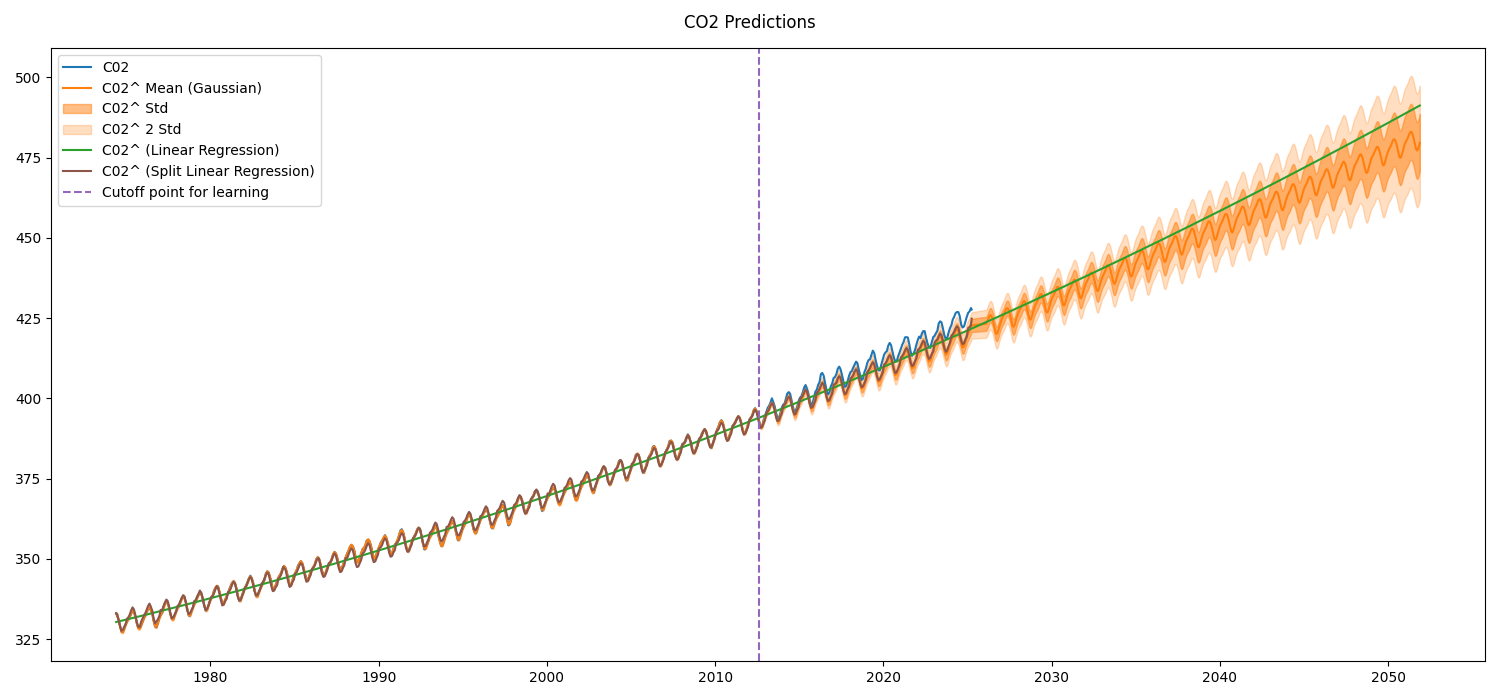

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), sharex=False, sharey=False)

ax.plot(gpp_table["Exact"].iloc[:len(labels_combined)], gpp_table["C02"].iloc[:len(labels_combined)], c="tab:blue", label="C02")
ax.plot(gpp_table["Exact"], gpp_table["C02^"], c="tab:orange", label="C02^ Mean (Gaussian)")
ax.fill_between(gpp_table["Exact"], gpp_table["C02^"] - gpp_table["Std"], gpp_table["C02^"] + gpp_table["Std"], label="C02^ Std ", color="tab:orange", alpha=.5)
ax.fill_between(gpp_table["Exact"], gpp_table["C02^"] - 2 * gpp_table["Std"], gpp_table["C02^"] + 2 * gpp_table["Std"], label="C02^ 2 Std ", color="tab:orange", alpha=.25)
ax.plot(linear_table["Exact"], linear_table["C02^"], c="tab:green", label="C02^ (Linear Regression)")
ax.plot(linear_table["Exact"].iloc[:len(labels_combined)], split_linear_table["C02^"], c="tab:brown", label="C02^ (Split Linear Regression)")
ax.axvline(x=x_test["Exact"].iloc[0], color='tab:purple', linestyle='--', label="Cutoff point for learning")
ax.legend()

fig.suptitle("CO2 Predictions")
fig.tight_layout()